In [2]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [40]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np

# Simple linear regression
Linear regression with only a slope, also known as simple linear regression, is a statistical technique used to model the relationship between a dependent variable and an independent variable when the relationship can be approximated by a straight line. In this case, we are considering a linear regression model with a single predictor variable and no intercept term.

To perform linear regression with only a slope, we need a set of paired observations (x, y), where x represents the independent variable (predictor) and y represents the dependent variable (response). The goal is to estimate the slope of the line that best fits the data points.

The formula for the simple linear regression model is:

$$y = \beta \cdot x + \epsilon$$

where:
- y is the dependent variable
- x is the independent variable
- β is the slope of the line
- ε is the error term representing the random variation or noise in the data

## Generate data

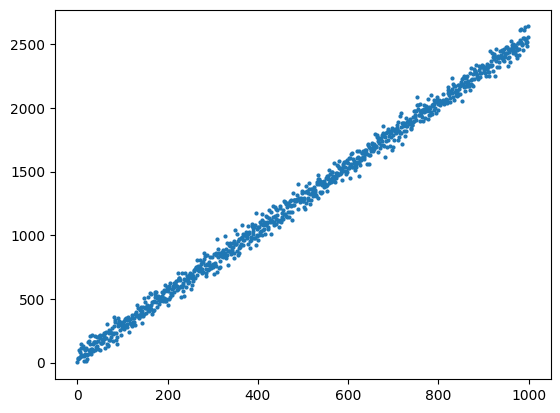

In [45]:
# Let us create some random data
size= 1000
mu, sigma = 50, 50 # mean and standard deviation
error=np.random.normal(mu, sigma, size)
x1 = np.arange(0, size)
y = 2.5*x1 + error
plt.plot(x1, y, 'o', markersize=2)
plt.show()

In [42]:
myRDD = sc.parallelize(zip(y,x1))
myRDD.take(5)

[(94.91483339758085, 0),
 (3.74632144867995, 1),
 (55.04893286413456, 2),
 (-10.102220443876035, 3),
 (-7.9305482331376, 4)]

## Calculating the slope using sklearn. 
The fit() method returns an instance of the LinearRegression class, which contains the slope of the line in its coef_ attribute.

In [43]:
from sklearn.linear_model import LinearRegression

X = np.stack([x1], axis=1)
reg = LinearRegression(fit_intercept=False).fit(X, y)
print(reg.coef_)

[2.57901022]


## Calculating the slope using linear algebra.
Calculate the coefficients of a linear regression model using the normal equation approach

$$
\hat{\beta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y
$$

Where:
- $\hat{\beta}$ represents the estimated coefficients of the linear regression model.
- $X$ is the matrix of input variables.
- $X^T$ denotes the transpose of $X$.
- $y$ is the vector of dependent variable values.
- $(X^T \cdot X)^{-1}$ represents the inverse of the matrix product $X^T \cdot X$.

In [44]:
# Let use solve this also with the exact linear algebra solution. 
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(beta_hat)

[2.57901022]


## Calculating the slope using gradient descent
Gradient descent is an iterative optimization algorithm used to find the minimum value of a function. In the context of machine learning, we can use gradient descent to find the optimal values of the coefficients in a parameterized model.

1. Calculation of the prediction with current regression coefficients:
   - Prediction: $y_{\text{prediction}} = m_{\text{current}} \cdot x_1$

2. Computation of the cost (for monitoring purposes):
   - Cost: $cost = \sum (y - y_{\text{prediction}})^2$

3. Calculation of the gradient:
   - Gradient: $m_{\text{gradient}} = \frac{-1}{n} \sum (x_1 \cdot (y - y_{\text{prediction}}))$

4. Update of the regression coefficient:
   - Updated coefficient: $m_{\text{current}} = m_{\text{current}} - \text{learningRate} \cdot m_{\text{gradient}}$

Here, the variable $n$ represents the number of data points in the dataset, $y$ is the dependent variable, $x_1$ is the independent variable, $m_{\text{current}}$ is the current value of the coefficient, and $\text{learningRate}$ is the learning rate (step size) used in the gradient descent algorithm.

In [39]:
# Now, we do gradient descent here with a very simple numpy array 
learningRate = 0.000001
num_iteration = 30 
m_current=0
n = float(size)

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    y_prediction = m_current * x1 
    # We compute costs just for monitoring 
    cost= sum (( y - y_prediction)**2)
    # calculate gradients. 
    m_gradient = (-1.0/n) * sum (x1 * (y - y_prediction) )
    print(i , "m=", m_current, " Cost=", cost)
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient 

0 m= 0  Cost= 2207850622.6020894
1 m= 0.85661185244252  Cost= 984510743.3915207
2 m= 1.4281145838951135  Cost= 439988536.7117607
3 m= 1.8094020609787795  Cost= 197615637.236982
4 m= 2.0637842925585193  Cost= 89732759.95634957
5 m= 2.2334995956637638  Cost= 41712889.601334564
6 m= 2.3467279604329288  Cost= 20338710.426319055
7 m= 2.422270132256696  Cost= 10824825.194474472
8 m= 2.4726693386347574  Cost= 6590088.905255353
9 m= 2.506294000756786  Cost= 4705160.613372598
10 m= 2.5287272488984227  Cost= 3866158.034962879
11 m= 2.5436939605447098  Cost= 3492708.6418960276
12 m= 2.5536792491702722  Cost= 3326482.157292911
13 m= 2.5603410992340785  Cost= 3252492.8974454277
14 m= 2.564785662424673  Cost= 3219559.4537414922
15 m= 2.567750926092571  Cost= 3204900.4111123933
16 m= 2.569729250675459  Cost= 3198375.507955171
17 m= 2.571049122563289  Cost= 3195471.200880809
18 m= 2.571929696871141  Cost= 3194178.4614517344
19 m= 2.5725171865501006  Cost= 3193603.048732393
20 m= 2.572909139982998  Cos

## Calculating the slope using gradient descent in PySpark
- `myRDD` contains tuples with the dependent variable $y$ as the first element (`x[0]`) and the independent variable $x$ as the second element (`x[1]`). 
- `size` represents the size of the RDD
- `learningRate` represents the learning rate (step size) used in the gradient descent algorithm.
- `beta` represents the current value of the coefficient.
- `gradient` represents the gradient of the cost function.
- `cost` represents the cost of the current loss function.

In [38]:
# Now we do gradient Decent on our RDD data set. 
learningRate = 0.000001
num_iteration = 30 

beta = 0
myRDD.cache()

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    
    gradientCost=myRDD.map(lambda x: (x[1], (x[0] - x[1] * beta) ))\
                        .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                        .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientCost[1]
    gradient=(-1.0/float(size))* gradientCost[0]
    print(i, "Beta", beta, " Cost", cost)
    beta = beta - learningRate * gradient    

0 Beta 0  Cost 2207850622.6020894
1 Beta 0.85661185244252  Cost 984510743.3915207
2 Beta 1.4281145838951135  Cost 439988536.7117607
3 Beta 1.8094020609787795  Cost 197615637.236982
4 Beta 2.0637842925585193  Cost 89732759.95634957
5 Beta 2.2334995956637638  Cost 41712889.601334564
6 Beta 2.3467279604329288  Cost 20338710.426319055
7 Beta 2.422270132256696  Cost 10824825.194474472
8 Beta 2.4726693386347574  Cost 6590088.905255353
9 Beta 2.506294000756786  Cost 4705160.613372598
10 Beta 2.5287272488984227  Cost 3866158.034962879
11 Beta 2.5436939605447098  Cost 3492708.6418960276
12 Beta 2.5536792491702722  Cost 3326482.157292911
13 Beta 2.5603410992340785  Cost 3252492.8974454277
14 Beta 2.564785662424673  Cost 3219559.4537414922
15 Beta 2.567750926092571  Cost 3204900.4111123933
16 Beta 2.569729250675459  Cost 3198375.507955171
17 Beta 2.571049122563289  Cost 3195471.200880809
18 Beta 2.571929696871141  Cost 3194178.4614517344
19 Beta 2.5725171865501006  Cost 3193603.048732393
20 Beta 